In [ ]:
from __future__ import division

import sys
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from tensorflow.keras import layers

from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')

width, height = 48, 48

datapoints = data['pixels'].tolist()

X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

y = pd.get_dummies(data['emotion']).to_numpy()

In [ ]:
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

In [ ]:
y0 = [1, 0, 0, 0, 0, 0, 0]
y1 = [0, 1, 0, 0, 0, 0, 0]
y2 = [0, 0, 1, 0, 0, 0, 0]
y3 = [0, 0, 0, 1, 0, 0, 0]
y4 = [0, 0, 0, 0, 1, 0, 0]
y5 = [0, 0, 0, 0, 0, 1, 0]
y6 = [0, 0, 0, 0, 0, 0, 1]

indexes0 = np.where(np.all(y == y0, axis=1))[0]
indexes1 = np.where(np.all(y == y1, axis=1))[0]
indexes2 = np.where(np.all(y == y2, axis=1))[0]
indexes3 = np.where(np.all(y == y3, axis=1))[0]
indexes4 = np.where(np.all(y == y4, axis=1))[0]
indexes5 = np.where(np.all(y == y5, axis=1))[0]
indexes6 = np.where(np.all(y == y6, axis=1))[0]

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
)

def augment_class(X, class_indexes, y_class):
    augmented_data_generator = datagen.flow(X[class_indexes], batch_size=64, shuffle=False)

    augmented_samples = []
    augmented_labels = []

    num_augmented_samples = 30
    for _ in range(num_augmented_samples):
        augmented_sample = augmented_data_generator.next()
        augmented_samples.append(augmented_sample)
        augmented_labels.append(np.array([y_class] * len(augmented_sample)))
    return np.vstack(augmented_samples), np.vstack(augmented_labels)  # Stack augmented samples and labels vertically

augmented_X0, augmented_y0 = augment_class(X, indexes0, y0)
augmented_X1, augmented_y1 = augment_class(X, indexes1, y1)
augmented_X2, augmented_y2 = augment_class(X, indexes2, y2)
augmented_X3, augmented_y3 = augment_class(X, indexes3, y3)
augmented_X4, augmented_y4 = augment_class(X, indexes4, y4)
augmented_X5, augmented_y5 = augment_class(X, indexes5, y5)
augmented_X6, augmented_y6 = augment_class(X, indexes6, y6)

X_augmented = np.concatenate((augmented_X0, augmented_X1, augmented_X2, augmented_X3, augmented_X4, augmented_X5, augmented_X6), axis=0)
y_augmented = np.concatenate((augmented_y0, augmented_y1, augmented_y2, augmented_y3, augmented_y4, augmented_y5, augmented_y6), axis=0)


In [ ]:
X = np.concatenate((X,X_augmented), axis=0)
y = np.concatenate((y,y_augmented), axis=0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

def vgg_block(num_convs, num_filters):
    block = tf.keras.Sequential()
    for _ in range(num_convs):
        block.add(layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same', activation='relu'))
    block.add(BatchNormalization())
    block.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    block.add(Dropout(0.25))
    return block

def vgg_block_512(num_convs, num_filters):
    block = tf.keras.Sequential()
    for _ in range(num_convs):
        block.add(layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
    block.add(BatchNormalization())
    block.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    block.add(Dropout(0.25))
    return block

def create_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(48, 48, 1)))
    model.add(vgg_block(2, 64))

    model.add(vgg_block(2, 128))
    model.add(vgg_block(3, 256))
    model.add(vgg_block_512(3, 512))
    model.add(vgg_block_512(3, 512))

    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(7, activation='softmax'))
    return model

model = create_model()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.000025), metrics=['accuracy'])

batch_size = 64
epochs = 40

history = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True)

fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")
print("Saved model to disk")

Epoch 1/40
616/616 [==============================] - 37s 40ms/step - loss: 28.9495 - accuracy: 0.2062 - val_loss: 26.6014 - val_accuracy: 0.1696
Epoch 2/40
616/616 [==============================] - 22s 36ms/step - loss: 23.8029 - accuracy: 0.2427 - val_loss: 21.2097 - val_accuracy: 0.2606
Epoch 3/40
616/616 [==============================] - 22s 36ms/step - loss: 18.7020 - accuracy: 0.2897 - val_loss: 16.4385 - val_accuracy: 0.3077
Epoch 4/40
616/616 [==============================] - 22s 37ms/step - loss: 14.3216 - accuracy: 0.3355 - val_loss: 12.5113 - val_accuracy: 0.3560
Epoch 5/40
616/616 [==============================] - 23s 37ms/step - loss: 10.8246 - accuracy: 0.3611 - val_loss: 9.3736 - val_accuracy: 0.3714
Epoch 6/40
616/616 [==============================] - 22s 36ms/step - loss: 8.1667 - accuracy: 0.3922 - val_loss: 7.0914 - val_accuracy: 0.4060
Epoch 7/40
616/616 [==============================] - 22s 36ms/step - loss: 6.2419 - accuracy: 0.4196 - val_loss: 5.4805 - val_

In [ ]:
ypredict = model.predict(X_valid)
ytrue = y_valid

y_pred = [np.argmax(sublist) for sublist in ypredict]
y_true = [np.argmax(sublist) for sublist in ytrue]

154/154 [==============================] - 1s 8ms/step


In [ ]:
cm = confusion_matrix(y_true, y_pred)

accuracy = 100 * (np.trace(cm) / np.sum(cm))
print('accuracy on validation set: ', accuracy.round(2))

accuracy on validation set:  62.63


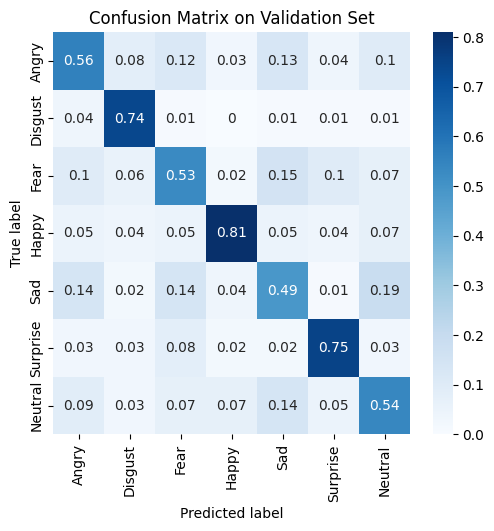

In [ ]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='pred').round(2),
  index=emotions.values(),
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Validation Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

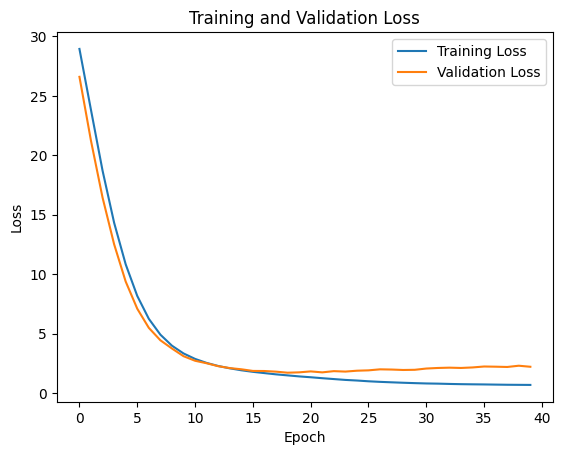

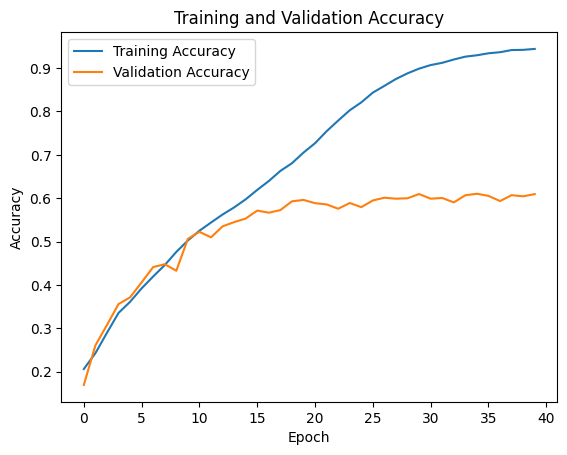

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


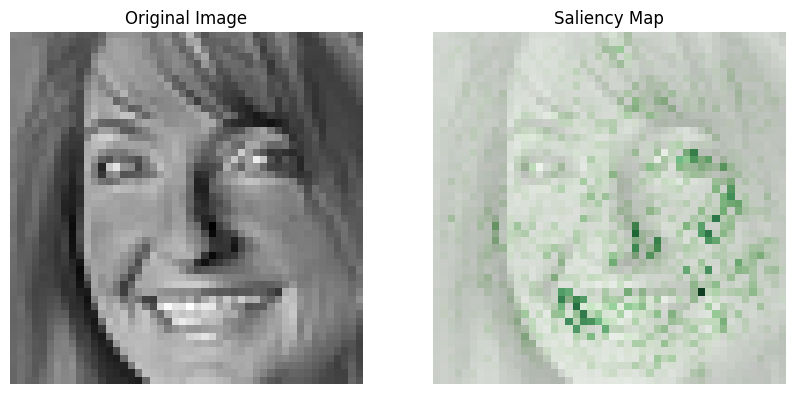

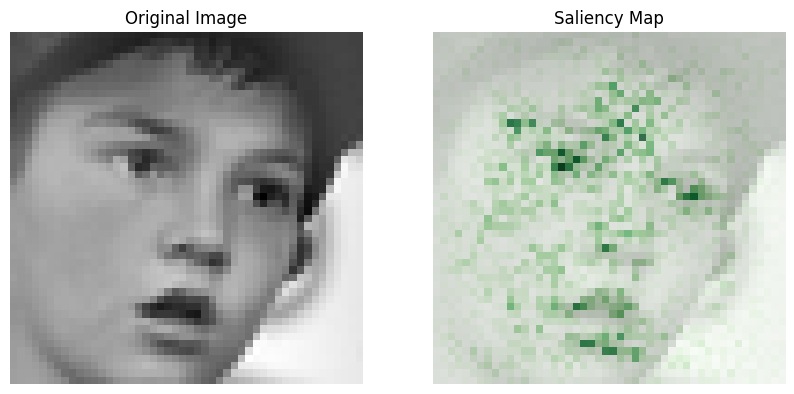

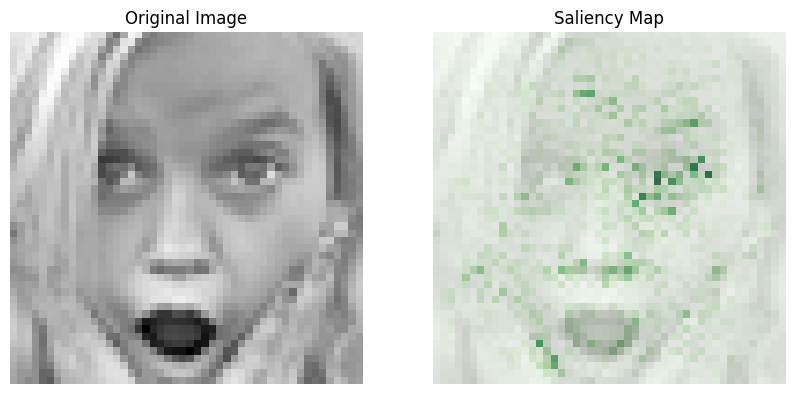

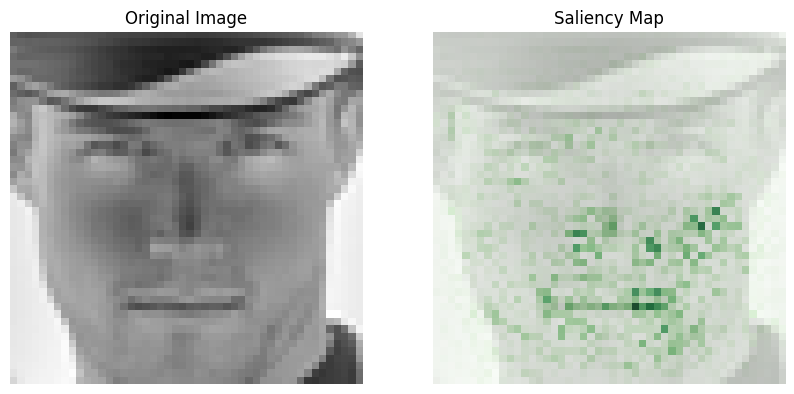

In [ ]:
def visualize_saliency_map(image_array):
    image_tensor = tf.convert_to_tensor(np.expand_dims(image_array, axis=0))

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        top_prediction = tf.argmax(predictions[0])
        top_score = predictions[:, top_prediction]

    gradient = tape.gradient(top_score, image_tensor)[0]

    saliency_map = tf.abs(gradient)

    image_array_rescaled = (image_array + 1) / 2

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image_array_rescaled, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(image_array_rescaled, cmap='gray')
    axs[1].imshow(saliency_map, cmap='Greens', alpha=0.7)
    axs[1].set_title('Saliency Map')
    axs[1].axis('off')

    plt.show()

visualize_saliency_map(X[105])
visualize_saliency_map(X[101])
visualize_saliency_map(X[686])
visualize_saliency_map(X[6325])